# ⚡ EnergiaPredictorES - Google Colab

## Sistema de Predicción de Demanda Eléctrica Nacional con Deep Learning

Este notebook ejecuta el pipeline completo del proyecto:
1. **Setup**: Instalación de dependencias y descarga de datos
2. **Preprocesamiento**: Limpieza y feature engineering
3. **Modelos Baseline**: XGBoost, LightGBM
4. **Deep Learning**: Temporal Fusion Transformer (TFT)
5. **Evaluación**: Comparativa de resultados

---

## 🔧 1. Setup del Entorno

In [1]:
# Verificar si estamos en Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print(f"🔹 Ejecutando en Google Colab: {IN_COLAB}")

🔹 Ejecutando en Google Colab: True


In [2]:
# Clonar el repositorio
!git clone https://github.com/nathanmarinas2/EnergiaPredictorES.git
%cd EnergiaPredictorES

Cloning into 'EnergiaPredictorES'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 36 (delta 2), reused 36 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 301.11 KiB | 1.51 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/EnergiaPredictorES


In [3]:
# Instalar dependencias
!pip install -q numpy pandas polars scikit-learn xgboost lightgbm
!pip install -q torch pytorch-lightning
!pip install -q darts pytorch-forecasting
!pip install -q matplotlib plotly seaborn
!pip install -q holidays pyyaml tqdm pyarrow
print("✅ Dependencias instaladas!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.8/399.8 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.8/159.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.1 MB/s eta 0:00:00
✅ Dependencias instaladas!


In [4]:
# Descomprimir datos
import zipfile
import os

zip_path = 'spain_energy_market.csv.zip'
extract_path = 'data/raw/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Datos descomprimidos en {extract_path}")
!ls -la data/raw/

✅ Datos descomprimidos en data/raw/
total 3072
drwxr-xr-x 2 root root    4096 Jan 29 17:01 .
drwxr-xr-x 4 root root    4096 Jan 29 17:01 ..
-rw-r--r-- 1 root root      39 Jan 29 17:01 .gitkeep
-rw-r--r-- 1 root root 3130960 Jan 29 17:01 spain_energy_market.csv


---
## 📊 2. Preprocesamiento de Datos

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import holidays
import warnings
warnings.filterwarnings('ignore')

# Configuración
PROJECT_ROOT = Path('.')
RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# Cargar datos
print("📂 Cargando datos...")
df_long = pd.read_csv(RAW_DIR / "spain_energy_market.csv", parse_dates=['datetime'])
print(f"   Shape: {df_long.shape}")
print(f"   Columnas: {df_long.columns.tolist()}")
df_long.head()

📂 Cargando datos...
   Shape: (40212, 6)
   Columnas: ['datetime', 'id', 'name', 'geoid', 'geoname', 'value']


,datetime,id,name,geoid,geoname,value
0,2014-01-01 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,25.280833
1,2014-01-02 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,39.924167
2,2014-01-03 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.992083
3,2014-01-04 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.091667
4,2014-01-05 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,13.587500


In [7]:
# Pivotar de formato long a wide
print("🔄 Pivotando datos...")
df = df_long.pivot_table(
    index='datetime',
    columns='name',
    values='value',
    aggfunc='first'
)
df.columns.name = None

# Renombrar columnas clave
rename_map = {
    'Demanda real': 'total load actual',
    'Demanda programada PBF total': 'total load forecast',
}

for old_name, new_name in list(rename_map.items()):
    for col in df.columns:
        if old_name.lower() in col.lower():
            rename_map[col] = new_name
            break

df = df.rename(columns=rename_map)
print(f"   ✅ Shape: {df.shape}")
print(f"   Período: {df.index.min()} a {df.index.max()}")

🔄 Pivotando datos...
   ✅ Shape: (1826, 20)
   Período: 2014-01-01 23:00:00 a 2018-12-31 23:00:00


In [8]:
# Feature Engineering Temporal
print("⏰ Añadiendo features temporales...")

# Features básicos
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# Features cíclicos
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Binarios
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_peak_morning'] = ((df['hour'] >= 7) & (df['hour'] <= 10)).astype(int)
df['is_peak_evening'] = ((df['hour'] >= 18) & (df['hour'] <= 21)).astype(int)
df['is_peak'] = (df['is_peak_morning'] | df['is_peak_evening']).astype(int)

# Festivos españoles
min_year = df.index.year.min()
max_year = df.index.year.max()
spain_holidays = holidays.Spain(years=range(min_year, max_year + 1))
df['is_holiday'] = df.index.date
df['is_holiday'] = df['is_holiday'].apply(lambda x: 1 if x in spain_holidays else 0)

print(f"   ✅ Añadidas features temporales")

⏰ Añadiendo features temporales...
   ✅ Añadidas features temporales


In [9]:
# Feature Engineering - Lags
print("📊 Añadiendo features de lag...")
target_col = 'total load actual'

# Lags horarios
for lag in [1, 2, 3, 6, 12, 24, 48, 168]:
    df[f'load_lag_{lag}h'] = df[target_col].shift(lag)

# Rolling statistics
for window in [6, 12, 24, 168]:
    df[f'load_rolling_mean_{window}h'] = df[target_col].shift(1).rolling(window).mean()
    df[f'load_rolling_std_{window}h'] = df[target_col].shift(1).rolling(window).std()

# Diferencias
df['load_diff_1h'] = df[target_col].diff(1)
df['load_diff_24h'] = df[target_col].diff(24)
df['load_diff_168h'] = df[target_col].diff(168)

# Ratio
df['load_ratio_24h'] = df[target_col] / df[target_col].shift(24)
df['load_ratio_168h'] = df[target_col] / df[target_col].shift(168)

# Limpiar infinitos
df = df.replace([np.inf, -np.inf], np.nan)

# Eliminar NaN
rows_before = len(df)
df = df.dropna()
print(f"   ✅ Eliminadas {rows_before - len(df)} filas con NaN")
print(f"   ✅ Dataset final: {df.shape}")

📊 Añadiendo features de lag...
   ✅ Eliminadas 1300 filas con NaN
   ✅ Dataset final: (526, 58)


In [10]:
# Guardar datos procesados
df.to_parquet(PROCESSED_DIR / "energy_processed.parquet")
print(f"✅ Datos guardados en {PROCESSED_DIR / 'energy_processed.parquet'}")

✅ Datos guardados en data/processed/energy_processed.parquet


---
## 📈 3. Análisis Exploratorio (EDA)

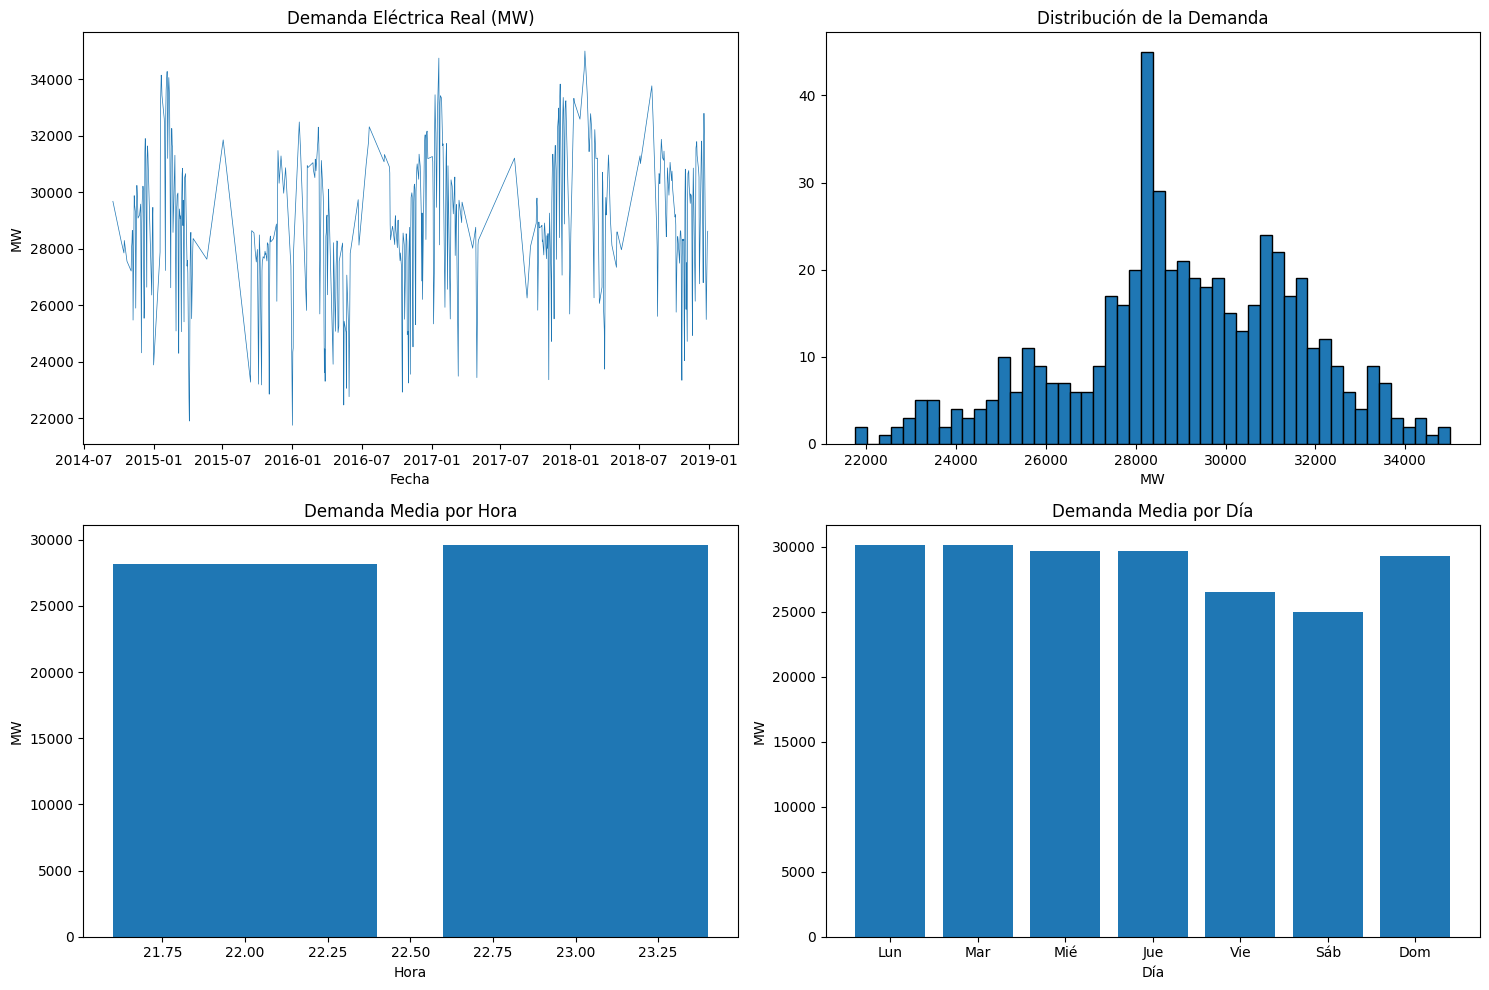

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Serie temporal
axes[0, 0].plot(df.index, df['total load actual'], linewidth=0.5)
axes[0, 0].set_title('Demanda Eléctrica Real (MW)')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('MW')

# 2. Distribución
axes[0, 1].hist(df['total load actual'], bins=50, edgecolor='black')
axes[0, 1].set_title('Distribución de la Demanda')
axes[0, 1].set_xlabel('MW')

# 3. Por hora del día
hourly_avg = df.groupby('hour')['total load actual'].mean()
axes[1, 0].bar(hourly_avg.index, hourly_avg.values)
axes[1, 0].set_title('Demanda Media por Hora')
axes[1, 0].set_xlabel('Hora')
axes[1, 0].set_ylabel('MW')

# 4. Por día de la semana
daily_avg = df.groupby('day_of_week')['total load actual'].mean()
days = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
axes[1, 1].bar(days, daily_avg.values)
axes[1, 1].set_title('Demanda Media por Día')
axes[1, 1].set_xlabel('Día')
axes[1, 1].set_ylabel('MW')

plt.tight_layout()
plt.savefig('reports/figures/eda_overview.png', dpi=150)
plt.show()

---
## 🤖 4. Modelos Baseline (XGBoost, LightGBM)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import pickle

# Métricas
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [13]:
# Preparar datos
target_col = 'total load actual'

# Excluir columnas que no son features
exclude_cols = [target_col, 'total load forecast']
feature_cols = [c for c in df.columns if c not in exclude_cols and df[c].dtype in ['float64', 'int64', 'int32']]

X = df[feature_cols]
y = df[target_col]

# Split temporal (80% train, 10% val, 10% test)
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

print(f"📊 Split de datos:")
print(f"   Train: {len(X_train)} filas ({df.index[0]} a {df.index[train_end-1]})")
print(f"   Val:   {len(X_val)} filas")
print(f"   Test:  {len(X_test)} filas ({df.index[val_end]} a {df.index[-1]})")
print(f"   Features: {len(feature_cols)}")

📊 Split de datos:
   Train: 420 filas (2014-09-15 22:00:00 a 2018-03-26 22:00:00)
   Val:   53 filas
   Test:  53 filas (2018-10-14 22:00:00 a 2018-12-27 23:00:00)
   Features: 56


In [14]:
# Entrenar modelos
results = []

# 1. Naive (h-24)
print("🔹 Naive (h-24)...")
y_pred_naive = df[target_col].shift(24).iloc[val_end:].values
results.append({
    'model': 'Naive (h-24)',
    'mae': mean_absolute_error(y_test, y_pred_naive),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_naive)),
    'mape': mape(y_test, y_pred_naive),
    'smape': smape(y_test, y_pred_naive)
})

# 2. Seasonal Naive (h-168)
print("🔹 Seasonal Naive (h-168)...")
y_pred_seasonal = df[target_col].shift(168).iloc[val_end:].values
results.append({
    'model': 'Seasonal Naive (h-168)',
    'mae': mean_absolute_error(y_test, y_pred_seasonal),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_seasonal)),
    'mape': mape(y_test, y_pred_seasonal),
    'smape': smape(y_test, y_pred_seasonal)
})

# 3. XGBoost
print("🔹 XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
y_pred_xgb = xgb_model.predict(X_test)
results.append({
    'model': 'XGBoost',
    'mae': mean_absolute_error(y_test, y_pred_xgb),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'mape': mape(y_test, y_pred_xgb),
    'smape': smape(y_test, y_pred_xgb)
})

# 4. LightGBM
print("🔹 LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred_lgb = lgb_model.predict(X_test)
results.append({
    'model': 'LightGBM',
    'mae': mean_absolute_error(y_test, y_pred_lgb),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_lgb)),
    'mape': mape(y_test, y_pred_lgb),
    'smape': smape(y_test, y_pred_lgb)
})

print("✅ Modelos baseline entrenados!")

🔹 Naive (h-24)...
🔹 Seasonal Naive (h-168)...
🔹 XGBoost...
🔹 LightGBM...
✅ Modelos baseline entrenados!


In [15]:
# Mostrar resultados baseline
results_df = pd.DataFrame(results).sort_values('mape')
print("\n" + "="*60)
print("📊 RESULTADOS BASELINE EN TEST SET")
print("="*60)
print(results_df.to_string(index=False))


📊 RESULTADOS BASELINE EN TEST SET
                 model         mae        rmse     mape    smape
              LightGBM  325.205967  435.552454 1.151768 1.153317
               XGBoost  410.008875  580.863849 1.460225 1.453099
Seasonal Naive (h-168) 2710.240839 3224.623075 9.519020 9.566202
          Naive (h-24) 2769.681494 3370.797617 9.785994 9.748075


---
## 🧠 5. Deep Learning - Temporal Fusion Transformer (TFT)

In [16]:
# Configurar GPU si está disponible
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🔹 Dispositivo: {device}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

🔹 Dispositivo: cuda
   GPU: Tesla T4


In [18]:
from darts import TimeSeries
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler

# Preparar serie temporal para Darts
print("📊 Preparando datos para TFT...")

# Los datos tienen timestamps con horas variables (22:00 y 23:00) por cambio horario
# Normalizamos a solo fecha para evitar problemas de frecuencia
df_tft = df.copy()
df_tft.index = df_tft.index.normalize()  # Convertir a solo fecha (00:00:00)

# Eliminar posibles duplicados por el cambio de horario
df_tft = df_tft[~df_tft.index.duplicated(keep='first')]
print(f"   Datos para TFT: {len(df_tft)} días")

# Serie del target
series = TimeSeries.from_dataframe(
    df_tft.reset_index(),
    time_col='datetime',
    value_cols='total load actual',
    freq='D',
    fill_missing_dates=True,  # Rellenar fechas faltantes si las hay
    fillna_value=None  # Interpolar valores faltantes
)

# Covariables conocidas en el futuro (solo las que tienen sentido a nivel diario)
# Quitamos 'hour' y 'hour_sin/cos' ya que estamos a nivel diario
future_covs_cols = ['day_of_week', 'month', 'is_weekend', 'is_holiday',
                    'day_sin', 'day_cos', 'month_sin', 'month_cos']
future_covs_cols = [c for c in future_covs_cols if c in df_tft.columns]

future_covariates = TimeSeries.from_dataframe(
    df_tft.reset_index(),
    time_col='datetime',
    value_cols=future_covs_cols,
    freq='D',
    fill_missing_dates=True
)

# Escalar
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

scaler_cov = Scaler()
future_covariates_scaled = scaler_cov.fit_transform(future_covariates)

# Split (80% train, 10% val, 10% test)
train_size = int(len(series) * 0.8)
val_size = int(len(series) * 0.1)

train_series = series_scaled[:train_size]
val_series = series_scaled[train_size:train_size + val_size]
test_series = series_scaled[train_size + val_size:]

print(f"   Train: {len(train_series)} puntos")
print(f"   Val:   {len(val_series)} puntos")
print(f"   Test:  {len(test_series)} puntos")

📊 Preparando datos para TFT...
   Datos para TFT: 526 días
   Train: 1252 puntos
   Val:   156 puntos
   Test:  157 puntos


In [25]:
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler

# Preparar serie temporal para Darts
print("📊 Preparando datos para TFT...")

# 1. Normalizar fechas (quitar horas)
df_tft = df.copy()
df_tft.index = df_tft.index.normalize()
df_tft = df_tft[~df_tft.index.duplicated(keep='first')] # Quitar dupes
print(f"   Datos para TFT: {len(df_tft)} días")

# 2. Definir Serie Target con relleno de interpolación
series = TimeSeries.from_dataframe(
    df_tft.reset_index(),
    time_col='datetime',
    value_cols='total load actual',
    freq='D',
    fill_missing_dates=True
)
# Interpolar para llenar huecos creados por missing dates
series = fill_missing_values(series, fill='auto')

# 3. Definir Covariables con relleno de interpolación
future_covs_cols = ['day_of_week', 'month', 'is_weekend', 'is_holiday',
                    'day_sin', 'day_cos', 'month_sin', 'month_cos']
future_covs_cols = [c for c in future_covs_cols if c in df_tft.columns]

future_covariates = TimeSeries.from_dataframe(
    df_tft.reset_index(),
    time_col='datetime',
    value_cols=future_covs_cols,
    freq='D',
    fill_missing_dates=True
)
# IMPORTANTE: Interpolar covariables también para evitar NaNs
future_covariates = fill_missing_values(future_covariates, fill='auto')

# 4. Escalar
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

scaler_cov = Scaler()
future_covariates_scaled = scaler_cov.fit_transform(future_covariates)

# 5. Split
train_size = int(len(series) * 0.8)
val_size = int(len(series) * 0.1)

train_series = series_scaled[:train_size]
val_series = series_scaled[train_size:train_size + val_size]
test_series = series_scaled[train_size + val_size:]

print(f"   Train: {len(train_series)} puntos")
print(f"   Val:   {len(val_series)} puntos")
print(f"   Test:  {len(test_series)} puntos")

# 6. Entrenar y Predecir
print("\n🧠 Entrenando TFT...")
tft_model = TFTModel(
    input_chunk_length=30,
    output_chunk_length=7,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=32,
    n_epochs=20, # Reducimos un poco para probar más rápido
    add_relative_index=True,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42,
    pl_trainer_kwargs={'accelerator': 'gpu' if torch.cuda.is_available() else 'cpu'}
)

tft_model.fit(
    series=train_series,
    future_covariates=future_covariates_scaled,
    val_series=val_series,
    val_future_covariates=future_covariates_scaled,
    verbose=True
)

print("\n📊 Generando predicciones...")
predictions_scaled = tft_model.predict(
    n=len(test_series),
    series=train_series.append(val_series),
    future_covariates=future_covariates_scaled
)

# 7. Métricas y Limpieza
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(test_series)

y_pred_tft = predictions.values().flatten()
y_true_tft = actual.values().flatten()

# Filtrar NaNs si quedan
mask = ~np.isnan(y_true_tft) & ~np.isnan(y_pred_tft)
if not mask.all():
    print(f"⚠️ Eliminados {len(y_pred_tft)-mask.sum()} NaNs residuales.")
    y_true_tft = y_true_tft[mask]
    y_pred_tft = y_pred_tft[mask]

if len(y_true_tft) > 0:
    tft_results = {
        'model': 'TFT',
        'mae': mean_absolute_error(y_true_tft, y_pred_tft),
        'rmse': np.sqrt(mean_squared_error(y_true_tft, y_pred_tft)),
        'mape': mape(y_true_tft, y_pred_tft),
        'smape': smape(y_true_tft, y_pred_tft)
    }
    print("="*30)
    print(f"RESULTADOS TFT:")
    print(f"MAE:  {tft_results['mae']:.2f}")
    print(f"RMSE: {tft_results['rmse']:.2f}")
    print(f"MAPE: {tft_results['mape']:.2f}%")
    print("="*30)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork      

📊 Preparando datos para TFT...
   Datos para TFT: 526 días
   Train: 1252 puntos
   Val:   156 puntos
   Test:  157 puntos

🧠 Entrenando TFT...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📊 Generando predicciones...


Predicting: |          | 0/? [00:00<?, ?it/s]

RESULTADOS TFT:
MAE:  1523.15
RMSE: 1825.43
MAPE: 5.13%


In [26]:
# Añadir TFT a resultados
results.append(tft_results)
final_results = pd.DataFrame(results).sort_values('mape')

print("\n" + "="*70)
print("📊 RESULTADOS FINALES - COMPARATIVA DE MODELOS")
print("="*70)
print(final_results.to_string(index=False))
print("="*70)

# Guardar resultados
final_results.to_csv('models/final_results.csv', index=False)
print("\n✅ Resultados guardados en models/final_results.csv")


📊 RESULTADOS FINALES - COMPARATIVA DE MODELOS
                 model         mae        rmse     mape    smape
              LightGBM  325.205967  435.552454 1.151768 1.153317
               XGBoost  410.008875  580.863849 1.460225 1.453099
                   TFT 1523.149877 1825.427080 5.125359 5.216338
Seasonal Naive (h-168) 2710.240839 3224.623075 9.519020 9.566202
          Naive (h-24) 2769.681494 3370.797617 9.785994 9.748075

✅ Resultados guardados en models/final_results.csv


---
## 📊 6. Comparativa Final de Resultados

In [27]:
# Añadir TFT a resultados
results.append(tft_results)
final_results = pd.DataFrame(results).sort_values('mape')

print("\n" + "="*70)
print("📊 RESULTADOS FINALES - COMPARATIVA DE MODELOS")
print("="*70)
print(final_results.to_string(index=False))
print("="*70)

# Guardar resultados
final_results.to_csv('models/final_results.csv', index=False)
print("\n✅ Resultados guardados en models/final_results.csv")


📊 RESULTADOS FINALES - COMPARATIVA DE MODELOS
                 model         mae        rmse     mape    smape
              LightGBM  325.205967  435.552454 1.151768 1.153317
               XGBoost  410.008875  580.863849 1.460225 1.453099
                   TFT 1523.149877 1825.427080 5.125359 5.216338
                   TFT 1523.149877 1825.427080 5.125359 5.216338
Seasonal Naive (h-168) 2710.240839 3224.623075 9.519020 9.566202
          Naive (h-24) 2769.681494 3370.797617 9.785994 9.748075

✅ Resultados guardados en models/final_results.csv


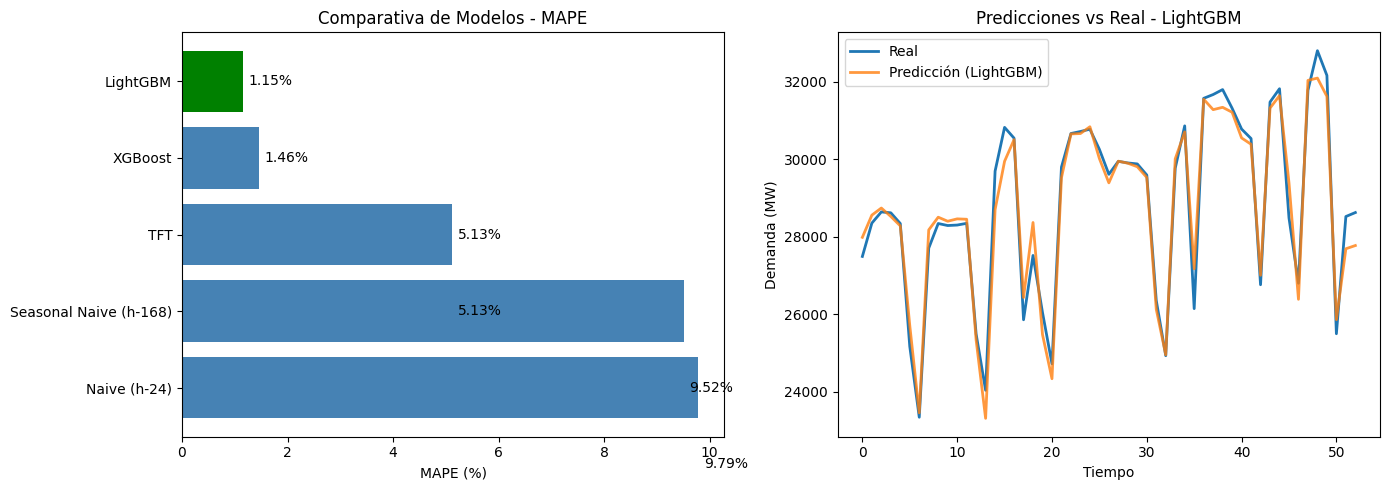


🏆 Mejor modelo: LightGBM con MAPE = 1.15%


In [28]:
# Visualización de resultados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Comparativa MAPE
colors = ['green' if x == final_results['mape'].min() else 'steelblue' for x in final_results['mape']]
axes[0].barh(final_results['model'], final_results['mape'], color=colors)
axes[0].set_xlabel('MAPE (%)')
axes[0].set_title('Comparativa de Modelos - MAPE')
axes[0].invert_yaxis()
for i, v in enumerate(final_results['mape']):
    axes[0].text(v + 0.1, i, f'{v:.2f}%', va='center')

# 2. Predicciones vs Real (mejor modelo)
best_model = final_results.iloc[0]['model']
if best_model == 'TFT':
    y_pred_best = y_pred_tft
    y_true_best = y_true_tft
elif best_model == 'LightGBM':
    y_pred_best = y_pred_lgb
    y_true_best = y_test.values
else:
    y_pred_best = y_pred_xgb
    y_true_best = y_test.values

axes[1].plot(y_true_best[-100:], label='Real', linewidth=2)
axes[1].plot(y_pred_best[-100:], label=f'Predicción ({best_model})', linewidth=2, alpha=0.8)
axes[1].set_xlabel('Tiempo')
axes[1].set_ylabel('Demanda (MW)')
axes[1].set_title(f'Predicciones vs Real - {best_model}')
axes[1].legend()

plt.tight_layout()
plt.savefig('reports/figures/model_comparison.png', dpi=150)
plt.show()

print(f"\n🏆 Mejor modelo: {best_model} con MAPE = {final_results.iloc[0]['mape']:.2f}%")

---
## 💾 7. Guardar Modelos

In [29]:
import os
os.makedirs('models', exist_ok=True)

# Guardar LightGBM
with open('models/lightgbm_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

# Guardar XGBoost
with open('models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Guardar TFT
tft_model.save('models/tft_model')

print("✅ Modelos guardados en /models")
!ls -la models/

✅ Modelos guardados en /models
total 1376
drwxr-xr-x 2 root root   4096 Jan 29 17:20 .
drwxr-xr-x 8 root root   4096 Jan 29 17:01 ..
-rw-r--r-- 1 root root    525 Jan 29 17:19 final_results.csv
-rw-r--r-- 1 root root     33 Jan 29 17:01 .gitkeep
-rw-r--r-- 1 root root 123941 Jan 29 17:20 lightgbm_model.pkl
-rw-r--r-- 1 root root 195049 Jan 29 17:20 tft_model
-rw------- 1 root root 739087 Jan 29 17:20 tft_model.ckpt
-rw-r--r-- 1 root root 325349 Jan 29 17:20 xgboost_model.pkl


---
## 📥 8. Descargar Resultados

In [30]:
# Descargar archivos importantes
if IN_COLAB:
    from google.colab import files

    # Comprimir modelos y resultados
    !zip -r results.zip models/ reports/figures/
    files.download('results.zip')
    files.download('models/final_results.csv')
    print("\n✅ Archivos descargados!")

  adding: models/ (stored 0%)
  adding: models/.gitkeep (stored 0%)
  adding: models/final_results.csv (deflated 45%)
  adding: models/tft_model.ckpt (deflated 22%)
  adding: models/tft_model (deflated 68%)
  adding: models/xgboost_model.pkl (deflated 72%)
  adding: models/lightgbm_model.pkl (deflated 64%)
  adding: reports/figures/ (stored 0%)
  adding: reports/figures/.gitkeep (stored 0%)
  adding: reports/figures/model_comparison.png (deflated 8%)
  adding: reports/figures/eda_overview.png (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Archivos descargados!


---
## ✅ Resumen

Este notebook ha ejecutado el pipeline completo del proyecto **EnergiaPredictorES**:

1. ✅ **Setup**: Clonado del repo e instalación de dependencias
2. ✅ **Preprocesamiento**: Feature engineering temporal y de lags
3. ✅ **EDA**: Análisis exploratorio de la demanda eléctrica
4. ✅ **Modelos Baseline**: XGBoost y LightGBM
5. ✅ **Deep Learning**: Temporal Fusion Transformer
6. ✅ **Evaluación**: Comparativa de métricas (MAPE, RMSE, MAE)

### Próximos pasos:
- Ajustar hiperparámetros del TFT
- Implementar N-BEATS como alternativa
- Añadir datos meteorológicos externos

---
**Autor**: Nathan Mariñas Pose  
**Proyecto**: EnergiaPredictorES